#### Training Evaluation

We attempted to train three models—**CLIP**, **BLIP**, and **ViLT**, however, due to lack of compute resources, we had to to stick to training CLIP, and ViLT

- Trained using a 60-20-20 split (train-valid-test)

The notebook has the following:

- Section 1: Training History Plot
- Section 2: Evaluation Metrics

In [66]:
import pandas as pd
import numpy as np

# Define question columns
question_cols = [
    "What limb is injured?",
    "Is the patient intubated?",
    "Where is the catheter inserted?",
    "Is there bleeding?",
    "Has the bleeding stopped?",
    "Is the patient moving?",
    "Is the patient breathing?",
    "Is there a tourniquet?",
    "Is there a chest tube?",
    "Are the patient and instruments secured?",
    "If a limb is missing which one?",
    "Is there mechanical ventilation?",
    "What is the position of the injury?"
]

CLASSES = [
    ['no limb is injured', 'left leg', 'left arm', 'right leg', 'right arm'],
    ["can't identify", 'no', 'yes'],
    ['no catheter is used', 'lower limb'],
    ['no', 'yes'],
    ['there is no bleeding', 'no', 'yes'],
    ["can't identify", 'yes', 'no'],
    ["can't identify", 'no', 'yes'],
    ['no', 'yes'],
    ['no', 'yes'],
    ['no', 'yes', "can't identify"],
    ['none', 'left arm', 'left leg', 'right leg'],
    ["can't identify", 'no', 'yes'],
    ['thorax', 'throat', "can't identify", 'lower limb', 'abdomen', 'upper limb']
]


In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def compute_metrics(y_true_df, y_pred_df):
    metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'AUC': []
    }

    for q in y_true_df.columns:
        y_true = y_true_df[q].astype(str).str.strip().str.lower()
        y_pred = y_pred_df[q].astype(str).str.strip().str.lower()

        encoder = LabelEncoder()
        y_true_enc = encoder.fit_transform(y_true)
        y_pred_enc = encoder.transform(y_pred)

        metrics['Accuracy'].append(accuracy_score(y_true_enc, y_pred_enc))
        metrics['Precision'].append(precision_score(y_true_enc, y_pred_enc, average='weighted', zero_division=0))
        metrics['Recall'].append(recall_score(y_true_enc, y_pred_enc, average='weighted', zero_division=0))
        metrics['F1 Score'].append(f1_score(y_true_enc, y_pred_enc, average='weighted', zero_division=0))

        try:
            # Compute multiclass AUC using one-vs-rest strategy
            y_true_bin = label_binarize(y_true_enc, classes=range(len(encoder.classes_)))
            y_pred_bin = label_binarize(y_pred_enc, classes=range(len(encoder.classes_)))
            auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
        except:
            auc = float('nan')  # fallback if AUC fails due to class imbalance

        metrics['AUC'].append(auc)

    return pd.DataFrame(metrics, index=y_true_df.columns)

def plot_metrics(metrics_df, title="Evaluation Metrics per Question"):
    metrics_df.plot(kind='bar', figsize=(14, 8))
    plt.title(title)
    plt.xlabel('Question')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(plt)


#### Training History Plot for CLIP and ViLT

In [68]:
import pandas as pd
import re
import matplotlib.pyplot as plt

def parse_log_file(model_name: str, log_path: str):
    """
    Parses a training log file for a given model and returns a DataFrame and best epoch info.
    """
    epochs, train_loss, val_loss, val_f1 = [], [], [], []

    with open(log_path, "r") as f:
        for line in f:
            match = re.match(r"Epoch (\d+) \| Train Loss: ([\d.]+) \| Val Loss: ([\d.]+) \| Val F1: ([\d.]+)", line.strip())
            if match:
                epochs.append(int(match.group(1)))
                train_loss.append(float(match.group(2)))
                val_loss.append(float(match.group(3)))
                val_f1.append(float(match.group(4)))

    log_df = pd.DataFrame({
        "Epoch": epochs,
        "Train Loss": train_loss,
        "Val Loss": val_loss,
        "Val F1": val_f1
    })

    best_epoch = epochs[val_f1.index(max(val_f1))]
    best_f1 = max(val_f1)

    print(f"Training Log Summary for {model_name.upper()}:")
    display(log_df)
    print(f"\nBest Epoch: {best_epoch} with Val F1 Score: {best_f1:.4f}")

    return log_df, best_epoch, best_f1


def plot_training_history(log_df: pd.DataFrame, best_epoch: int, model_name: str):
    """
    Plots the training history from a DataFrame for a given model.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(log_df["Epoch"], log_df["Train Loss"], label='Train Loss')
    plt.plot(log_df["Epoch"], log_df["Val Loss"], label='Val Loss')
    plt.plot(log_df["Epoch"], log_df["Val F1"], label='Val F1 Score')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title(f"Training History - {model_name.upper()}")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Training Log Summary for CLIP:


,Epoch,Train Loss,Val Loss,Val F1
0,1,0.6335,2.2188,0.8701
1,2,0.5066,1.8443,0.8395
2,3,0.4282,1.5854,0.8980
3,4,0.3738,1.4089,0.9047
4,5,0.3343,1.2842,0.9109
5,6,0.3032,1.1637,0.9318
6,7,0.2774,1.0778,0.9323
7,8,0.2562,1.0147,0.9333
8,9,0.2377,1.0170,0.9300
9,10,0.2209,0.9096,0.9464



Best Epoch: 10 with Val F1 Score: 0.9464


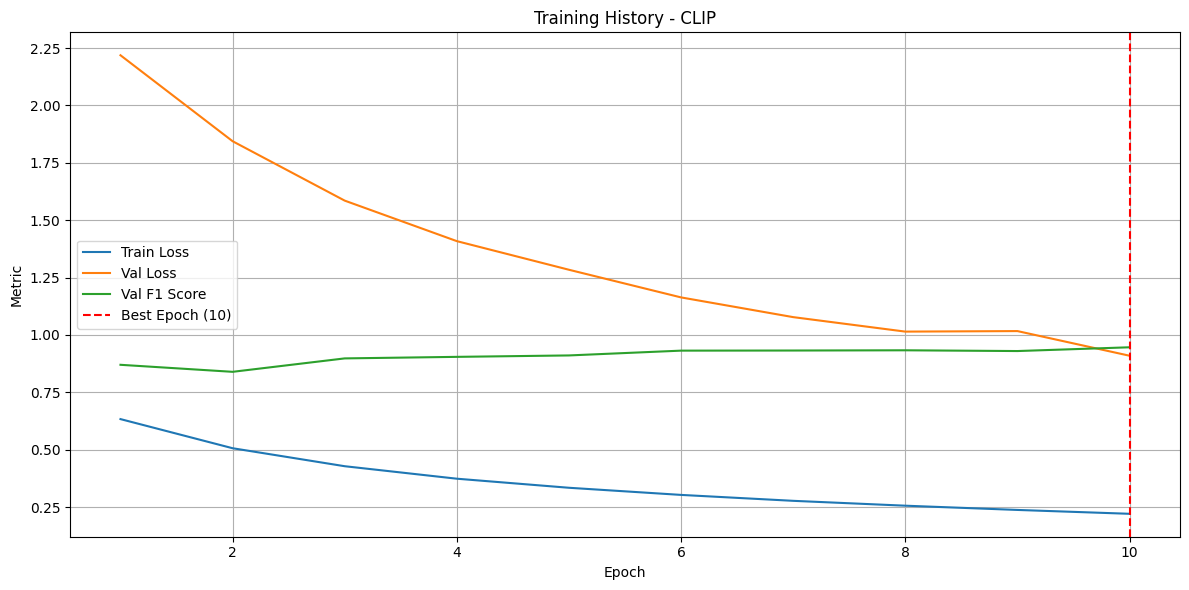

In [69]:
model_name = "clip"
log_path = "pt_img/clip.txt"

log_df, best_epoch, best_f1 = parse_log_file(model_name, log_path)
plot_training_history(log_df, best_epoch, model_name)

Training Log Summary for VILT:


,Epoch,Train Loss,Val Loss,Val F1
0,1,0.1751,0.3355,0.9760
1,2,0.0430,0.2373,0.9856
2,3,0.0236,0.2342,0.9825
3,4,0.0154,0.1534,0.9868
4,5,0.0111,0.1340,0.9921
5,6,0.0075,0.1282,0.9926
6,7,0.0058,0.1731,0.9885
7,8,0.0071,0.1469,0.9914



Best Epoch: 6 with Val F1 Score: 0.9926


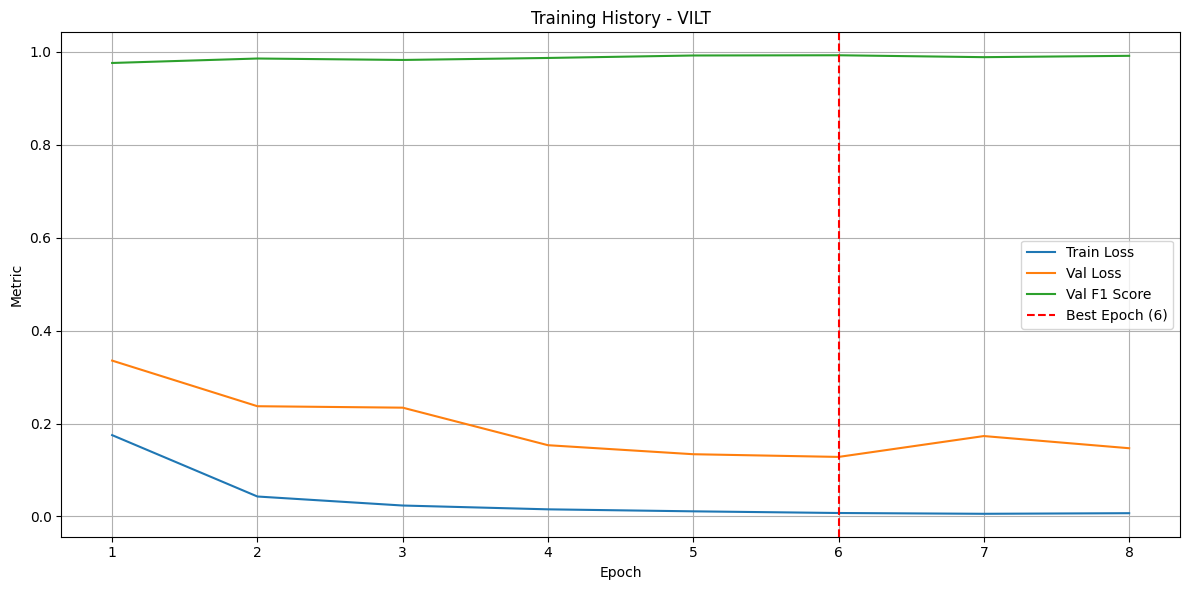

In [70]:
model_name = "vilt"
log_path = "pt_img/vilt.txt"

log_df, best_epoch, best_f1 = parse_log_file(model_name, log_path)
plot_training_history(log_df, best_epoch, model_name)

#### Evaluation Metrics Heatmap

In [71]:
vilt_preds_ft = pd.read_csv("predictions/vilt_predictions.csv")
clip_preds_ft = pd.read_csv("predictions/clip_predictions.csv")
test_df = pd.read_csv("data_csv/test_data.csv")

def normalize_series(series):
    return series.astype(str).str.strip().str.lower()


In [72]:
def align_predictions_with_test(test_df, predictions_df):
    # Pivot predictions: each question becomes a column
    pred_wide = predictions_df.pivot_table(
        index=["video_id", "frame"],
        columns="question",
        values="predicted_answer",
        aggfunc='first'  # handles duplicates safely
    ).reset_index()

    # Rename columns for compatibility
    pred_wide.columns.name = None

    # Align with test_df
    merged = test_df[["video_id", "frame"]].merge(pred_wide, on=["video_id", "frame"], how="left")

    return merged


##### Fine-tuned CLIP Model

In [73]:
# Align the long-format predictions to test_df structure
aligned_clip_df = align_predictions_with_test(test_df, clip_preds_ft)
aligned_vilt_df = align_predictions_with_test(test_df, vilt_preds_ft)

# Now evaluate as normal
metrics_clip_df = compute_metrics(test_df[question_cols], aligned_clip_df[question_cols])
metrics_vilt_df = compute_metrics(test_df[question_cols], aligned_vilt_df[question_cols])

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

def normalize_series(series):
    """Convert series to lowercase strings with whitespace stripped."""
    return series.astype(str).str.strip().str.lower()

def plot_confusion_matrices_grouped_by_question(test_df, pred_df1, pred_df2, question_cols, model_names=("Model 1", "Model 2"), figsize=(5, 4)):
    """
    For each question, plot side-by-side confusion matrices comparing two models.
    Each row corresponds to one question.
    """
    import math

    n = len(question_cols)
    fig, axes = plt.subplots(n, 2, figsize=(2 * figsize[0], n * figsize[1]))
    if n == 1:
        axes = axes.reshape(1, 2)

    for idx, q in enumerate(question_cols):
        y_true = normalize_series(test_df[q])
        labels = sorted(y_true.dropna().unique())

        for model_idx, (pred_df, model_name) in enumerate(zip([pred_df1, pred_df2], model_names)):
            y_pred = normalize_series(pred_df[q])
            cm = confusion_matrix(y_true, y_pred, labels=labels)

            ax = axes[idx, model_idx]
            sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="YlOrBr", ax=ax)
            ax.set_title(f"{q} ({model_name})", fontsize=9)
            ax.set_xlabel("Predicted", fontsize=8)
            ax.set_ylabel("Actual", fontsize=8)
            ax.tick_params(axis='x', rotation=45)
            ax.tick_params(axis='y', rotation=0)

    plt.subplots_adjust(hspace=0.8)
    plt.tight_layout()
    plt.show()

def create_summary_metric_heatmap(metrics_dict):
    """
    Create a multi-metric heatmap comparing all models.
    Each row = Question, each column = Model + Metric.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Build long-form DataFrame
    records = []
    for model_name, df in metrics_dict.items():
        for q in df.index:
            for metric in df.columns:
                records.append({
                    "Question": q,
                    "Model": model_name,
                    "Metric": metric,
                    "Score": df.loc[q, metric]
                })

    long_df = pd.DataFrame(records)

    # Create pivot for heatmap
    long_df["Model_Metric"] = long_df["Model"] + " | " + long_df["Metric"]
    pivot = long_df.pivot_table(index="Question", columns="Model_Metric", values="Score")

    # Reorder columns to group by model with spacing
    cols = sorted(pivot.columns, key=lambda x: (x.split(" | ")[0], x.split(" | ")[1]))
    pivot = pivot[cols]

    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Score"})
    plt.title("Evaluation Metrics per Question and Model", fontsize=14)
    plt.xlabel("Model + Metric", fontsize=12)
    plt.ylabel("Question", fontsize=12)
    plt.xticks(rotation=30, ha="right")  # rotate x-axis slightly
    plt.tight_layout(pad=1.5)
    plt.show()



In [75]:
model_names = ["CLIP", "VILT"]
aligned_models = {
    "CLIP": aligned_clip_df,
    "VILT": aligned_vilt_df,
}
metrics_dict = {
    "CLIP": metrics_clip_df,
    "VILT": metrics_vilt_df,
}

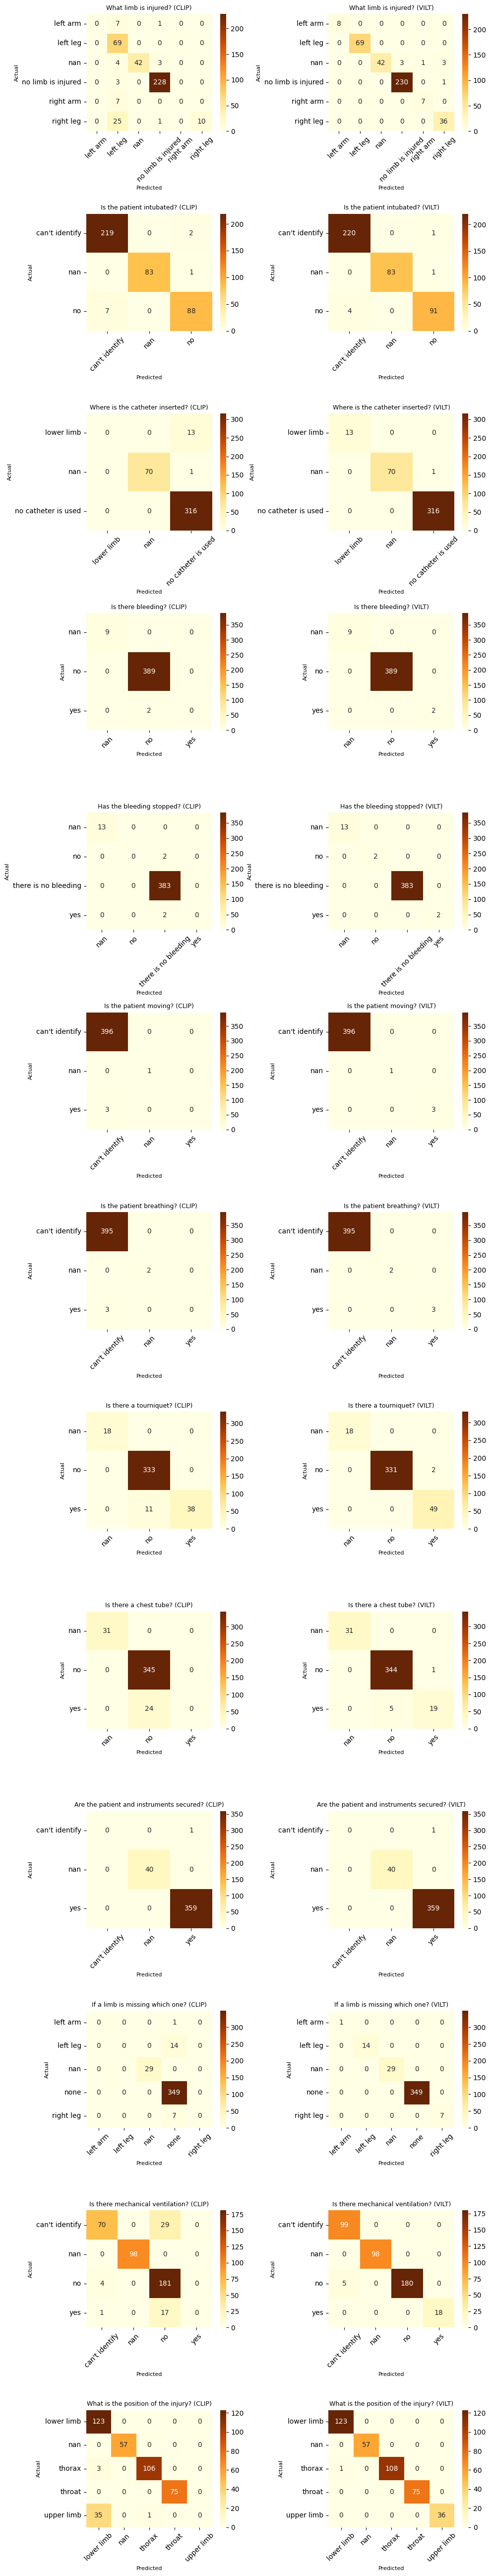

In [76]:
# Call like this — correctly unpacking from the dict
plot_confusion_matrices_grouped_by_question(
    test_df,
    aligned_models["CLIP"],
    aligned_models["VILT"],
    question_cols,
    model_names=model_names
)

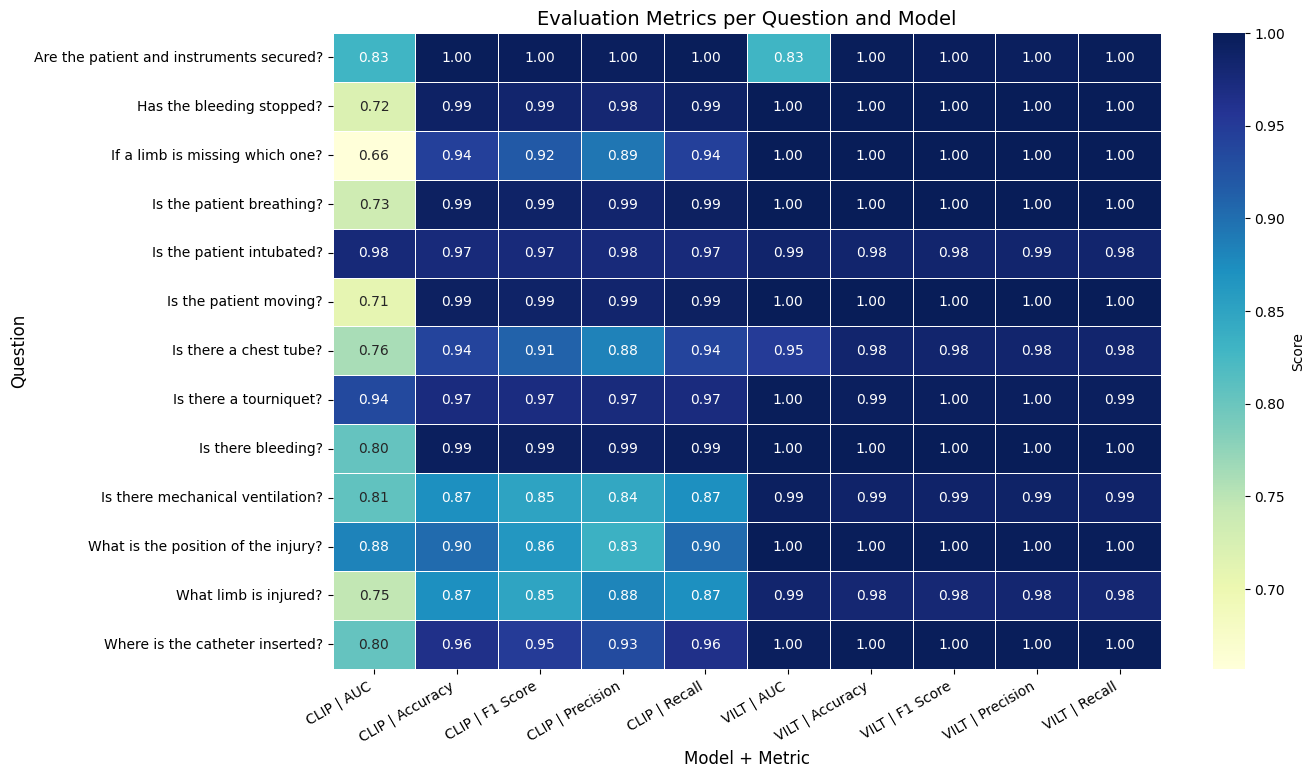

In [79]:
# Call heatmap normally
create_summary_metric_heatmap(metrics_dict)

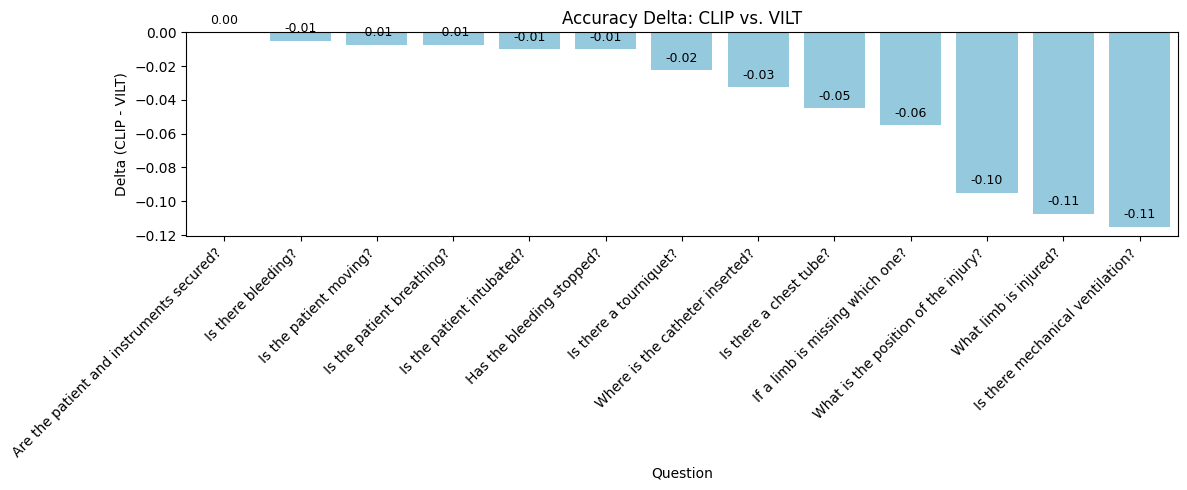

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
model_compare = metrics_clip_df[["Accuracy"]].rename(columns={"Accuracy": "CLIP"})
model_compare["VILT"] = metrics_vilt_df["Accuracy"]
model_compare["Delta (CLIP - VILT)"] = model_compare["CLIP"] - model_compare["VILT"]
model_compare["Question"] = model_compare.index

# Sort by delta
model_compare_sorted = model_compare.sort_values("Delta (CLIP - VILT)", ascending=False)

# Plot
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=model_compare_sorted, x="Question", y="Delta (CLIP - VILT)", color="skyblue")

# Annotate values on top
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 4),  # 4 points above bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.title("Accuracy Delta: CLIP vs. VILT")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Question")
plt.ylabel("Delta (CLIP - VILT)")
plt.tight_layout()
plt.show()
